In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from loaders.ultrasound_dataset import USDataset
from transforms.ultrasound_transforms import Moco2TrainTransforms, Moco2EvalTransforms, AutoEncoderTrainTransforms

from torchvision import transforms

import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
import SimpleITK as sitk
import numpy as np

import pickle

from monai.transforms import (    
    AsChannelFirst,
    AddChannel,
    Compose,    
    RandFlip,
    RandRotate,
    CenterSpatialCrop,
    ScaleIntensityRange,
    RandAdjustContrast,
    RandGaussianNoise,
    RandGaussianSmooth
)


In [2]:
mount_point = "/work/jprieto/data/remote/GWH/Groups/FAMLI/Shared/C1_ML_Analysis"
df_test = pd.read_csv(os.path.join(mount_point, "CSV_files", "extract_frames_test.csv"))


In [3]:
train_df = pd.read_parquet(os.path.join(mount_point, "CSV_files", "extract_frames_blind_sweeps_train_prediction_noflyto_minscore1e-4.parquet"))
train_df = train_df.query("tag != 'BPD' and tag != 'HC' and tag != 'AC' and tag != 'CRL' and tag != 'FL'").reset_index(drop=True)

In [6]:

# score_min = 0
# score_max = 1e-4
# batch_size = 32

# filtered_df = train_df.query("{score_min:.10f} <= score and score <= {score_max:.10f}".format(score_min=score_min, score_max=score_max)).reset_index(drop=True)
# print(score_min, score_max, len(filtered_df))


0 0.0001 0


In [7]:
# img = []    
# for i in range(batch_size):
#     img_path = filtered_df.loc[np.random.randint(len(filtered_df))]["img_path"]    
#     img_path = os.path.join(mount_point, img_path)
#     img.append(sitk.GetArrayFromImage(sitk.ReadImage(img_path)))
# img = np.array(img)    
# fig = px.imshow(img, facet_col=0, binary_string=True, facet_col_wrap=8, facet_row_spacing=0.01, height=8192)        

# fig

ValueError: high <= 0

In [8]:
# score_min = 1e-4
# score_max = 1
# batch_size = 32

# filtered_df = train_df.query("{score_min:.10f} <= score and score <= {score_max:.10f}".format(score_min=score_min, score_max=score_max)).reset_index(drop=True)
# print(score_min, score_max, len(filtered_df))

0.0001 1 1361234


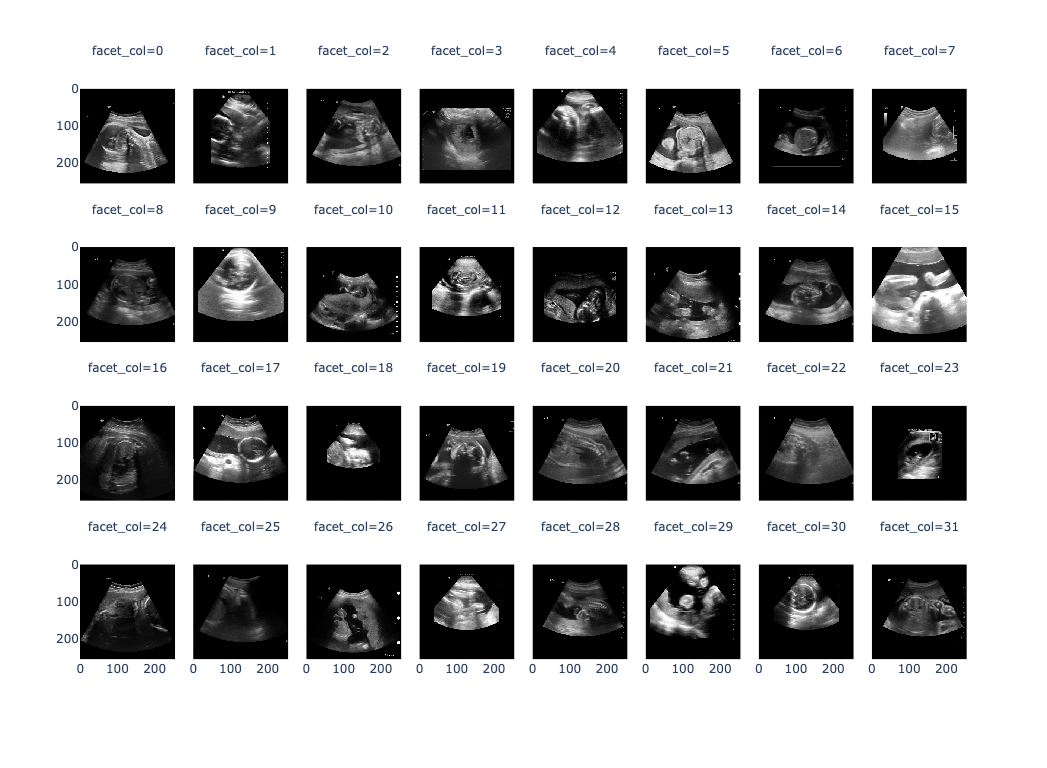

In [16]:
filtered_df = train_df
img = []    
for i in range(batch_size):
    img_path = filtered_df.loc[np.random.randint(len(filtered_df))]["img_path"]    
    img_path = os.path.join(mount_point, img_path)
    img.append(sitk.GetArrayFromImage(sitk.ReadImage(img_path)))
img = np.array(img)    
fig = px.imshow(img, facet_col=0, binary_string=True, facet_col_wrap=8, facet_row_spacing=0.01, height=768)        

fig

In [34]:
from torchvision import transforms
from torch import nn
import torch 

class SaltAndPepper:    
    def __init__(self, prob=0.2):
        self.prob = prob
    def __call__(self, x):
        noise_tensor = torch.rand(x.shape)
        salt = torch.max(x)
        pepper = torch.min(x)
        x[noise_tensor < self.prob/2] = salt
        x[noise_tensor > 1-self.prob/2] = pepper
        return x

    
class GaussianNoise(nn.Module):    
    def __init__(self, mean=0.0, std=0.1):
        super(GaussianNoise, self).__init__()
        self.mean = mean
        self.std = std
    def forward(self, x):
        return x + torch.normal(mean=self.mean, std=self.std, size=x.size())
    
class AutoEncoderTrainTransforms:
    def __init__(self, height: int = 128):

        # image augmentation functions
        self.train_transform = transforms.Compose(
            [
                ScaleIntensityRange(a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0),
                transforms.ColorJitter(brightness=[0.4, 1.5], contrast=[0.5, 1.5], saturation=[0.5, 1.5], hue=[-.2, .2]),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(180),
                transforms.RandomResizedCrop(size=height, scale=(0.8, 1.0), ratio=(0.75, 1.33333))
                # transforms.RandomResizedCrop(size=height, scale=(0.4, 1.0), ratio=(0.75, 1.333)),
                # GaussianNoise(std=0.01),
                # transforms.GaussianBlur(5, sigma=(2.99, 3.0))
                # transforms.Pad(64),
                # transforms.RandomCrop(height),                
                
            ]
        )

    def __call__(self, inp):
        # q = self.train_transform(inp)
        q = inp
        k = self.train_transform(inp)
        # k = inp
        return q, k
    
transform = AutoEncoderTrainTransforms(256)
test_ds = USDataset(df_test, transform=transform, img_column="img_path", mount_point=mount_point)

0.0 248.0


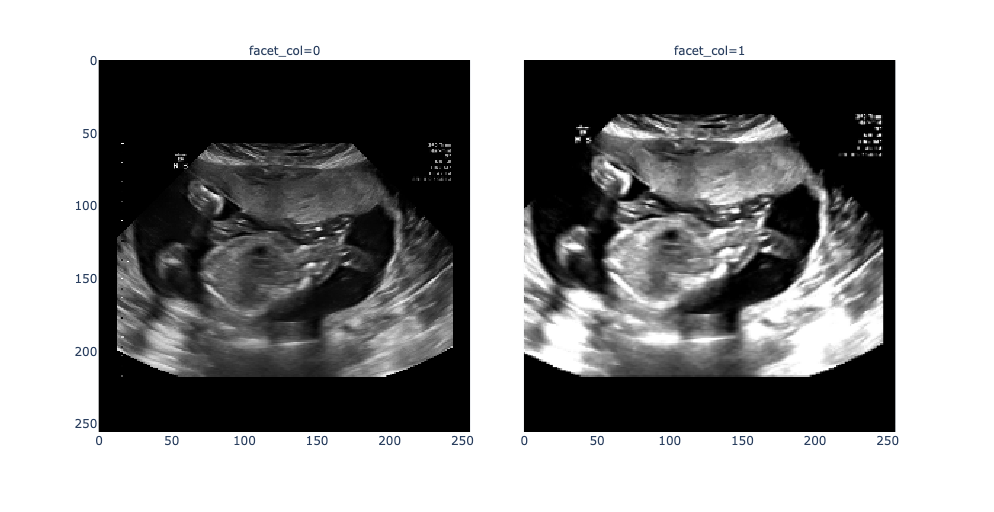

In [41]:

img1, img2 = test_ds[np.random.randint(len(test_ds))]
img1 = img1.permute(1,2,0).numpy()
img2 = img2.permute(1,2,0).numpy()

print(np.min(img1), np.max(img1))

img1 = ((img1 - np.min(img1))/(np.max(img1) - np.min(img1)))*255
img2 = ((img2 - np.min(img2))/(np.max(img2) - np.min(img2)))*255

fig = px.imshow(np.array([img1, img2]), facet_col=0, binary_string=True, height=512)        
fig